In [19]:
#%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

### Dummy data

In [20]:
# Generate dummy data
# We will use y = x*10 + 12 + noise
n_points = 50
x = np.random.rand(n_points, 1)
y = x *10 + 12 + np.random.rand(n_points, 1)*5

# For later use
data = np.array([x, y]).T
data = data.reshape(n_points, 2)

### Plot the data

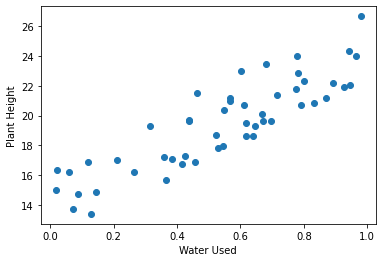

In [ ]:
plt.scatter(x, y) # Tip: Could also used plt.scatter(data[:, 0], data[:, 1])
plt.xlabel('Water Used')
plt.ylabel('Plant Height')
plt.show()

### Plotting the guess along side the data
Let's start with: $y=x+2$

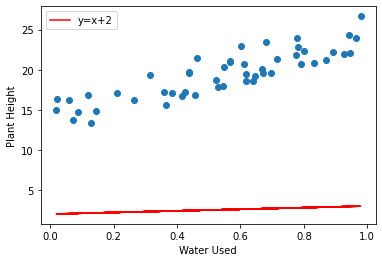

In [ ]:
plt.scatter(x, y)

# Plot y=x
plt.plot(x, x+2, color='red', label='y=x+2')


plt.xlabel('Water Used')
plt.ylabel('Plant Height')
plt.legend()
plt.show()

### Defining cost function

In [ ]:
def compute_cost(w, b):
    x, y = data[:, 0], data[:, 1]
    cost = 0
    for i in range(n_points):
        cost += (y[i] - (w * x[i] + b))**2
    return cost

### If we fix $b$, how does the cost vary with the $w$?

Text(0, 0.5, 'cost')

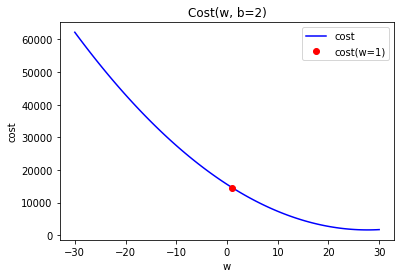

In [ ]:
# Compute cost for b fixed at 2
w_values = np.linspace(-30, 30, 100)
b = 2
cost_values = [compute_cost(w, b) for w in w_values]

# Plot
plt.title('Cost(w, b=2)')
plt.plot(w_values, cost_values, color='blue', label='cost')
plt.plot(1, compute_cost(1, b), 'o', color='red', label='cost(w=1)')
plt.legend()
plt.xlabel('w')
plt.ylabel('cost')
plt.show()

### Compute the cost function surface

In [ ]:
# Compute surface
w_values = np.linspace(-10, 30, 100)
b_values = np.linspace(-10, 30, 100)

cost = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        cost[i, j] = compute_cost(w_values[i], b_values[j])

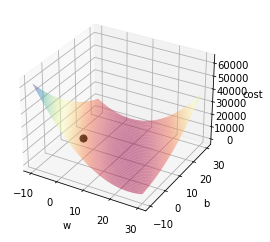

In [ ]:
X, Y = np.meshgrid(w_values, b_values)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, cost, cmap='Spectral', alpha=0.5)
ax.scatter(1, 2, compute_cost(1, 2), color='black', s=50)
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('cost')
plt.show()

### Code use for the surface animation

(you may skip it)

In [ ]:
# Initialize fig and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialization of the animation
def init():
    X, Y = np.meshgrid(w_values, b_values)

    ax.plot_surface(X, Y, cost, cmap='Spectral', alpha=0.2)
    ax.scatter(1, 2, compute_cost(1, 2), color='black', s=50)
    ax.set_xlabel('w')
    ax.set_ylabel('b')
    ax.set_zlabel('cost')

    return fig,

# Animation function
def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=20, blit=True)
# Save
anim.save('basic_animation.mp4', fps=10, bitrate=500, codec="libx264", extra_args=['-pix_fmt', 'yuv420p'],dpi=100)

Defining a neural network with just one neuron, effectivelly a perceptron due to its simplicity

In [ ]:
# I'm using pyTorch for this
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron,self).__init__()
        # This will define the only layer of our network
        # Representing the perceptron
        self.layer1 = nn.Linear(in_features=1, out_features=1)

    def forward(self, t):
        # Ignore this line, this is done because pytorch expects a batch of data
        t = torch.tensor(t, dtype=torch.float32).unsqueeze(dim=0).unsqueeze(dim=0)

        # Pass input through layer
        t = self.layer1(t)

        # Return the output of layer 1
        return t

Perceptron = Perceptron()

print(Perceptron)

Perceptron(
  (layer1): Linear(in_features=1, out_features=1, bias=True)
)


We can even acess our automatically generated parameters for our perceptron

In [ ]:
# Get weights and bias
w = Perceptron.layer1.weight.data.numpy()
b = Perceptron.layer1.bias.data.numpy()

print(f"w: {w}")
print(f"b: {b}")

w: [[0.5615276]]
b: [-0.16406906]


Let's set it to our initial guess

In [ ]:
# Manually set weights and bias
Perceptron.layer1.weight.data = torch.tensor([[1.0]])
Perceptron.layer1.bias.data = torch.tensor([[2.0]])

w = Perceptron.layer1.weight.data.numpy()
b = Perceptron.layer1.bias.data.numpy()

print(f"w: {w}")
print(f"b: {b}")

w: [[1.]]
b: [[2.]]


### Let's start training

In [ ]:
optimizer = optim.Adam(Perceptron.parameters(), lr=1)

print("[+] Starting training..")

loss_history = []
weight_history = []
bias_history = []

for epoch in range(150):

    # All the X values and Y values
    Xs = data[:, 0]
    Ys = data[:, 1]
    
    # Predict the y values using our perceptron
    preds = []
    for x in Xs:
        prediction = Perceptron(x)
        preds.append(prediction)

    # Compute loss
    loss = 0
    for i in range(n_points):
        # The diference between the prediction and the real value squared
        loss += (preds[i] - Ys[i])**2 
    loss = loss / n_points

    optimizer.zero_grad()   # This will set all the gradients on cache to zero
    loss.backward()     # Compute the gradient vector for the current loss
    optimizer.step()    # Update the weights and bias according to the gradient vector

    #if epoch  == 0:
    loss_history.append(loss.item())
    w = Perceptron.layer1.weight.data.numpy()[0][0]
    b = Perceptron.layer1.bias.data.numpy()[0][0]
    weight_history.append(w)
    bias_history.append(b)

    if epoch % 25 == 0:
        print("Epoch", epoch, "| Loss:", loss.item(), "| w:", w, "| b:", b)
        

print("[+] Training finished")

[+] Starting training..
Epoch 0 | Loss: 292.3969421386719 | w: 2.0 | b: 3.0


/home/acujl/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


Epoch 25 | Loss: 14.984807014465332 | w: 13.622051 | b: 15.129091
Epoch 50 | Loss: 2.4339287281036377 | w: 10.726425 | b: 13.308907
Epoch 75 | Loss: 2.1803276538848877 | w: 10.166373 | b: 13.661968
Epoch 100 | Loss: 2.0882179737091064 | w: 9.942296 | b: 14.067619
Epoch 125 | Loss: 2.076925039291382 | w: 9.71477 | b: 14.20321
[+] Training finished


#### Final Values:

In [ ]:
weight_history[-1], bias_history[-1]

(9.597846, 14.256597)

In [ ]:
# Compute surface
w_values = np.linspace(-5, 20, 100)
b_values = np.linspace(-5, 20, 100)

cost = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        cost[i, j] = compute_cost(w_values[i], b_values[j])

## Code use for the other Animations

In [ ]:
x, y = data[:, 0], data[:, 1]

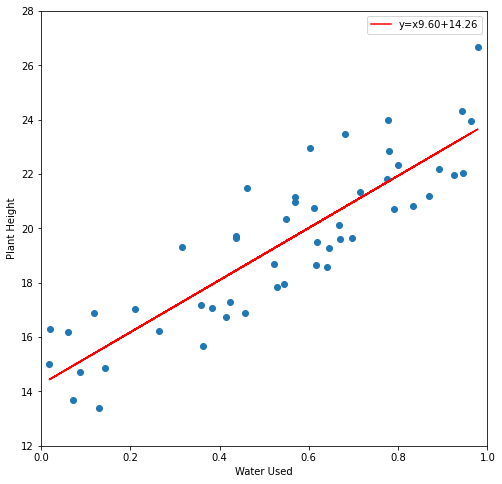

In [ ]:
# 3d plot 3
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

def init():
    ax.scatter(x, y)

    ax.set_xlabel('Water Used')
    ax.set_ylabel('Plant Height')
    
    ax.set(xlim=(0, 1), ylim=(12, 28))
    return fig,

def animate(i):
    plt.cla()
    ax.scatter(x, y)

    w, b = weight_history[i], bias_history[i]
    ax.plot(x, x*w+b, color='red', label='y=x{:.2f}+{:.2f}'.format(w, b))
    ax.set_xlabel('Water Used')
    ax.set_ylabel('Plant Height')
    plt.legend()
    
    ax.set(xlim=(0, 1), ylim=(12, 28))
    
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(weight_history), interval=1500, blit=True)
# Save
anim.save('basic_animation3.mp4', fps=10, bitrate=500, codec="libx264", extra_args=['-pix_fmt', 'yuv420p'],dpi=100)

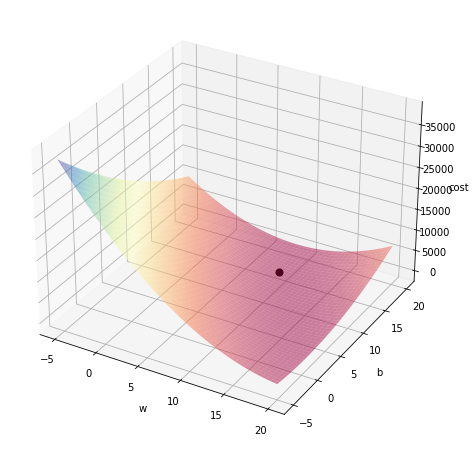

In [ ]:
# 3d plot 2
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

def init():
    # Plot the surface
    X, Y = np.meshgrid(w_values, b_values)
    ax.plot_surface(X, Y, cost, cmap='Spectral', alpha=0.5)

    ax.set_xlabel('w')
    ax.set_ylabel('b')
    ax.set_zlabel('cost')
    return fig,

def animate(i):
    plt.cla()

    # Plot the surface
    X, Y = np.meshgrid(w_values, b_values)
    ax.plot_surface(X, Y, cost, cmap='Spectral', alpha=0.5)

    ax.scatter(weight_history[i], bias_history[i], compute_cost(weight_history[i], bias_history[i]), color='black', s=50)

    ax.set_xlabel('w')
    ax.set_ylabel('b')
    ax.set_zlabel('cost')
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(weight_history), interval=1500, blit=True)
# Save
anim.save('basic_animation2.mp4', fps=10, bitrate=500, codec="libx264", extra_args=['-pix_fmt', 'yuv420p'],dpi=100)